# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

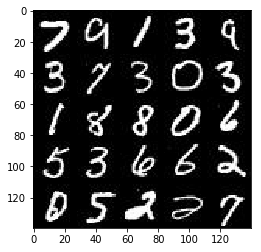

In [12]:
data_dir = '/input'
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

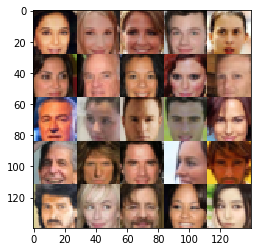

In [4]:
import helper
import os
from glob import glob
from matplotlib import pyplot

data_dir = '/input'

show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [3]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height,image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2,kernel_initializer=tf.random_normal_initializer(stddev=0.01), padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2,kernel_initializer=tf.random_normal_initializer(stddev=0.01), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2,kernel_initializer=tf.random_normal_initializer(stddev=0.01), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        #flat = tf.reshape(relu3, (-1, 4*4*256))
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [5]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    #print(out_channel_dim)
    reuse=True
    if(is_train==True):
        reuse=False
    with tf.variable_scope('generator',reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.01), padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        #print(x2)
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2,kernel_initializer=tf.random_normal_initializer(stddev=0.01), padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        #print(x3)
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1,kernel_initializer=tf.random_normal_initializer(stddev=0.01), padding='SAME')
        # 28x28x3 now
        #print(logits)
        out = tf.tanh(logits) 
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
import numpy as np
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    #smooth = 0.1
    #d_model_real = tf.ones_like(d_model_real) * (1 - smooth)
    #fake_labels = tf.zeros_like(d_model_fake)
    #g_labels    = tf.ones_like(d_model_fake)
    
    #d_loss_real = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_model_real))
    #d_loss_fake = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=fake_labels))
    #g_loss = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * np.random.uniform(0.0, 0.3)))
    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    if data_image_mode == 'RGB': 
        out_channel_dim=3
    else:
        out_channel_dim=1
    inputs_real, inputs_z, learning_rates=model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss=model_loss(inputs_real, inputs_z, out_channel_dim)
    d_train_opt, g_train_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    losses = []
    steps = 0
    show_every = 100
    print_every=10
    #samples=[]
    n_samples=25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                #print(steps)
                # TODO: Train Model
                # Get images, reshape and rescale to pass to D
                images = batch_images#batch_images[0].reshape((batch_size,data_shape))
                images = images*2 
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z,inputs_real: images})
                
            # At the end of each epoch, get the losses and print them out
                if steps % print_every == 0:
                    train_loss_d = sess.run(d_loss, {inputs_z: batch_z, inputs_real: images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})  
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    # Sample from generator as we're training for viewing afterwards
                    show_generator_output(sess, n_samples, inputs_z, out_channel_dim, data_image_mode)
           # samples.append(gen_samples)
           # saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8543... Generator Loss: 0.3794
Epoch 1/2... Discriminator Loss: 1.5115... Generator Loss: 0.5067
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 0.7804
Epoch 1/2... Discriminator Loss: 1.5805... Generator Loss: 1.4903
Epoch 1/2... Discriminator Loss: 2.9459... Generator Loss: 0.0981
Epoch 1/2... Discriminator Loss: 1.9139... Generator Loss: 2.1254
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 1.1799
Epoch 1/2... Discriminator Loss: 1.5874... Generator Loss: 0.4186
Epoch 1/2... Discriminator Loss: 1.5067... Generator Loss: 0.4697
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.6378


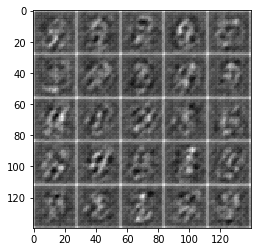

Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 1.1450
Epoch 1/2... Discriminator Loss: 1.9215... Generator Loss: 0.2603
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.6456
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 1.0787
Epoch 1/2... Discriminator Loss: 1.2733... Generator Loss: 1.1202
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 1.3963
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.6239
Epoch 1/2... Discriminator Loss: 1.5778... Generator Loss: 0.4066
Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 1.0437
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 1.2400


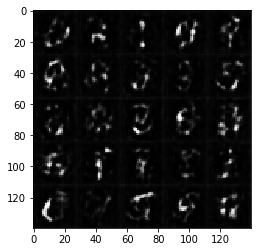

Epoch 1/2... Discriminator Loss: 1.5636... Generator Loss: 1.6905
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 1.0395
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 1.0897
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.4687
Epoch 1/2... Discriminator Loss: 1.2567... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 0.8324
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 1.2065
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 0.8895
Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 0.9411
Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 0.6164


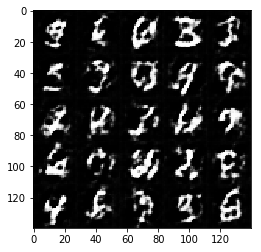

Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.5887
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 0.6975
Epoch 1/2... Discriminator Loss: 1.3936... Generator Loss: 0.5366
Epoch 1/2... Discriminator Loss: 1.2408... Generator Loss: 0.8326
Epoch 1/2... Discriminator Loss: 1.3318... Generator Loss: 1.2290
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 1.2471
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 0.6917
Epoch 1/2... Discriminator Loss: 1.2951... Generator Loss: 0.6923


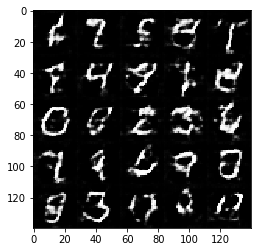

Epoch 1/2... Discriminator Loss: 1.2499... Generator Loss: 0.8670
Epoch 1/2... Discriminator Loss: 1.5208... Generator Loss: 0.4397
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 1.2727
Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 0.4439
Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 0.8744
Epoch 1/2... Discriminator Loss: 1.3042... Generator Loss: 0.7183
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.6108
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.8665
Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 0.5000


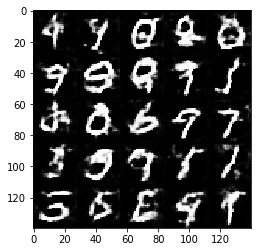

Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 0.8569
Epoch 1/2... Discriminator Loss: 1.4786... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 1.2566
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 0.6254
Epoch 1/2... Discriminator Loss: 1.5018... Generator Loss: 0.4406
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 1.0997
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.2906... Generator Loss: 0.7693


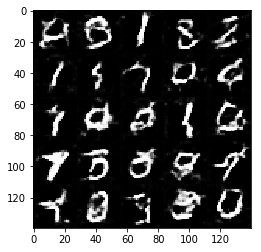

Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.2893... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.5771
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.9571
Epoch 1/2... Discriminator Loss: 1.3026... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 0.6805
Epoch 1/2... Discriminator Loss: 1.3711... Generator Loss: 0.5802
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 0.7702


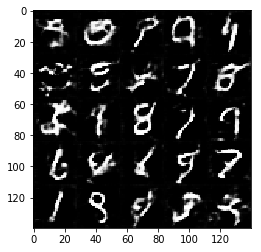

Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 0.6480
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 0.8453
Epoch 1/2... Discriminator Loss: 1.4588... Generator Loss: 0.4718
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.5904
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 1.2278
Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 0.6410
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 0.5344
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.8137


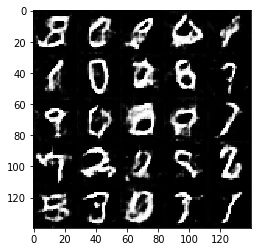

Epoch 1/2... Discriminator Loss: 1.3180... Generator Loss: 0.6484
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 1.0214
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.6101
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.9321
Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 0.5671
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.9598
Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 0.7204
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 1.2140
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.9637


Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.6940
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 1.4170
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.6534
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 0.7790
Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.4756
Epoch 1/2... Discriminator Loss: 1.2907... Generator Loss: 0.7711


Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 0.6756
Epoch 1/2... Discriminator Loss: 1.2858... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.7417
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 0.7849
Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 0.5579
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.7533


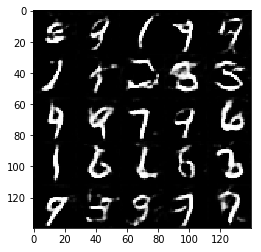

Epoch 1/2... Discriminator Loss: 1.2718... Generator Loss: 0.9055
Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 0.6585
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 1.2718... Generator Loss: 0.8563
Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.6810
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 1.2099
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 0.9249
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.5777


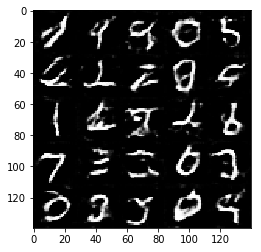

Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 1.4200
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.7842
Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 1.1386
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.4982
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 0.6188
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.2643... Generator Loss: 1.0772
Epoch 1/2... Discriminator Loss: 1.9604... Generator Loss: 0.2569
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.6555


Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.7177
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.7094
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.9360
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 1.2907... Generator Loss: 0.8669
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 0.8840
Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.6868


Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.8922
Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 0.6356
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 0.6852
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.5859
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.8001
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 0.5367


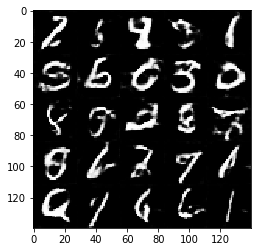

Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.7754
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.6605
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 1.2933... Generator Loss: 0.7388
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 1.0607
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 0.8677
Epoch 1/2... Discriminator Loss: 1.3300... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.5338


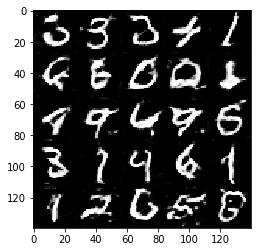

Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.6397
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 0.8110
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.7804
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.2926... Generator Loss: 0.7122
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.7846
Epoch 1/2... Discriminator Loss: 1.2494... Generator Loss: 0.8881
Epoch 1/2... Discriminator Loss: 1.2910... Generator Loss: 0.7200


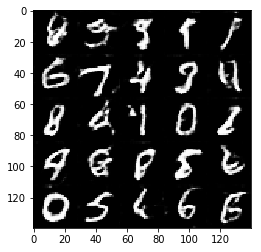

Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 0.8290
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.5850
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 1.1534
Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 1.5532... Generator Loss: 0.4086
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.8589
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.9780
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 0.7385
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.6018


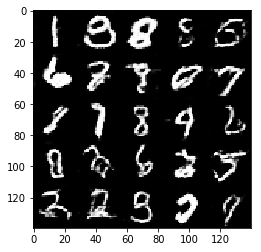

Epoch 1/2... Discriminator Loss: 1.4472... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.5692
Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 0.6070
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.6202
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.8226
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.6043
Epoch 2/2... Discriminator Loss: 1.5019... Generator Loss: 1.4134
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 1.0305


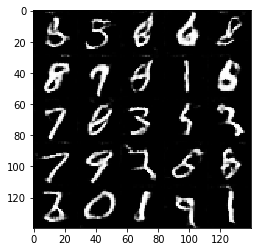

Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 1.2464... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 0.8798
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.9828
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 0.8960
Epoch 2/2... Discriminator Loss: 1.4069... Generator Loss: 0.5281
Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 0.6875
Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 0.6957


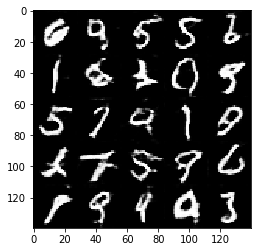

Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.8154
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.8725
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 1.4854
Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.4779
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.5444
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.6051
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.5615
Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 1.0395


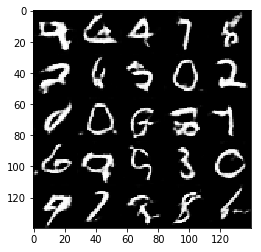

Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 1.1936
Epoch 2/2... Discriminator Loss: 1.4707... Generator Loss: 0.4594
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.9310
Epoch 2/2... Discriminator Loss: 1.2645... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.2747... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.5754
Epoch 2/2... Discriminator Loss: 1.3221... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 0.8496


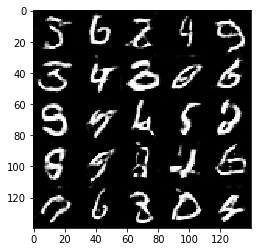

Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 1.1169
Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.6749
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 1.2941... Generator Loss: 0.6952
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 1.0440
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.5706
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.6127
Epoch 2/2... Discriminator Loss: 1.3180... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.4254... Generator Loss: 0.5215


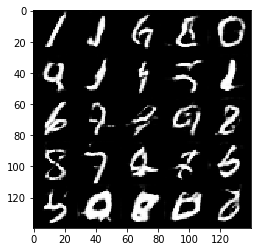

Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.8826
Epoch 2/2... Discriminator Loss: 1.2506... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.6490
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.6197
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 1.5069... Generator Loss: 0.4443


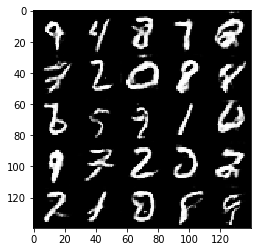

Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 1.0119
Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 0.4442
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.8474
Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 0.5269
Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 0.5943
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 0.7479
Epoch 2/2... Discriminator Loss: 1.4672... Generator Loss: 0.5068
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.7348


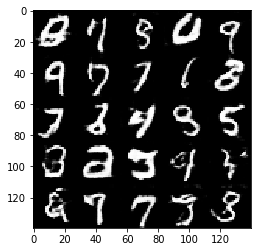

Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 0.7789
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.5430
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 0.6282
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.9828
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 1.2762... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 0.8746
Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 0.7470


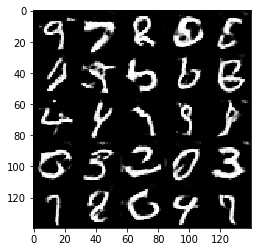

Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 0.5608
Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 1.2050
Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 0.7563
Epoch 2/2... Discriminator Loss: 1.2893... Generator Loss: 0.7440
Epoch 2/2... Discriminator Loss: 1.4737... Generator Loss: 0.4807
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 0.6386
Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 0.7867
Epoch 2/2... Discriminator Loss: 1.2634... Generator Loss: 1.1224


Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 1.0937
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 0.7154
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.7056
Epoch 2/2... Discriminator Loss: 1.2374... Generator Loss: 0.8563
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.5755
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.5830
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 1.2162


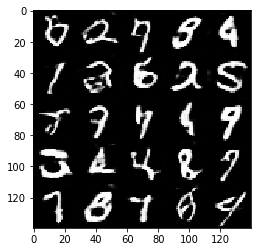

Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.9320
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.7391
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.7672
Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 1.0407
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.9104
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 1.2211... Generator Loss: 0.8857
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 0.6329


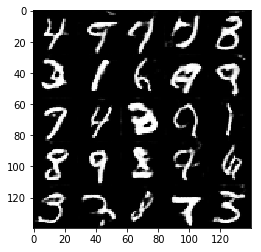

Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 0.7381
Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 0.8950
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.5336
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.7684
Epoch 2/2... Discriminator Loss: 1.2338... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.9557
Epoch 2/2... Discriminator Loss: 1.2310... Generator Loss: 0.9338
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.5436
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.7201


Epoch 2/2... Discriminator Loss: 1.1986... Generator Loss: 1.1858
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.6986
Epoch 2/2... Discriminator Loss: 1.5340... Generator Loss: 0.4522
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.7561
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.8913
Epoch 2/2... Discriminator Loss: 1.2859... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 1.3542... Generator Loss: 0.5890
Epoch 2/2... Discriminator Loss: 1.3202... Generator Loss: 0.6287
Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 0.8276
Epoch 2/2... Discriminator Loss: 1.2372... Generator Loss: 0.8488


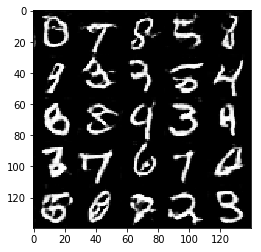

Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 0.5967
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.5933
Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 0.6692
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 1.2881... Generator Loss: 0.7064
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 1.4046
Epoch 2/2... Discriminator Loss: 1.4721... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 0.7582
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.6398


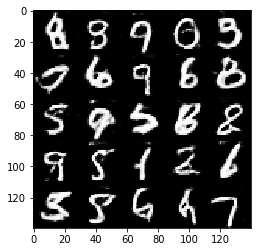

Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.6924
Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 1.1281
Epoch 2/2... Discriminator Loss: 1.2847... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 1.2183... Generator Loss: 0.9951
Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 0.8136
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 0.7108
Epoch 2/2... Discriminator Loss: 1.4908... Generator Loss: 0.4714
Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.5525


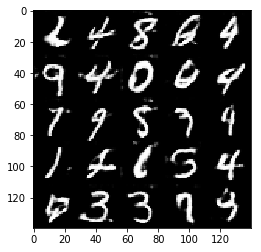

Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.5579
Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 0.9337
Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 0.4339
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 0.8459
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 1.1283
Epoch 2/2... Discriminator Loss: 1.2711... Generator Loss: 0.8374
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 0.8137
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.9052
Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 0.7019


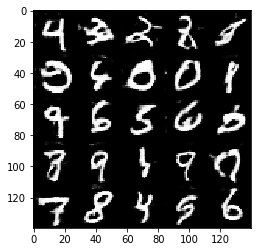

Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.7199
Epoch 2/2... Discriminator Loss: 1.2473... Generator Loss: 0.9177
Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 1.0365
Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 1.2352... Generator Loss: 0.9983
Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 0.9971
Epoch 2/2... Discriminator Loss: 1.4962... Generator Loss: 0.4658
Epoch 2/2... Discriminator Loss: 1.5007... Generator Loss: 1.4872
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.8099
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 0.6589


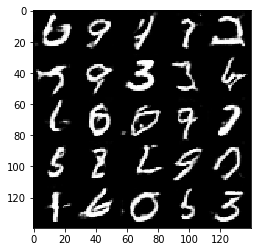

Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.6868
Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 0.9156
Epoch 2/2... Discriminator Loss: 1.5028... Generator Loss: 0.4460
Epoch 2/2... Discriminator Loss: 1.2561... Generator Loss: 0.7572
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 0.7410
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.7636
Epoch 2/2... Discriminator Loss: 1.2538... Generator Loss: 1.0275
Epoch 2/2... Discriminator Loss: 1.3244... Generator Loss: 0.6282
Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 0.7683


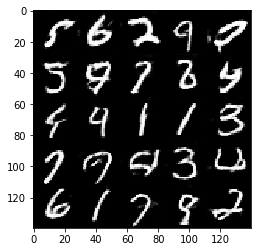

Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.6388
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 1.0222
Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 1.0567
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 1.0476
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.6415
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 1.1099
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.5424


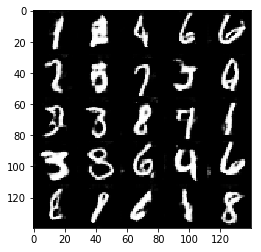

Epoch 2/2... Discriminator Loss: 1.2535... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.5875
Epoch 2/2... Discriminator Loss: 1.2842... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 1.1582
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 1.1724


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.2358
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.4970
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 3.4474
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.4552
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.7264... Generator Loss: 0.3107
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.4754


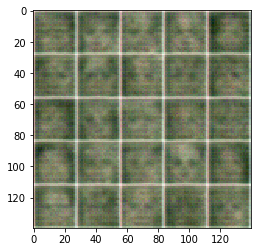

Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.3672
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.9159


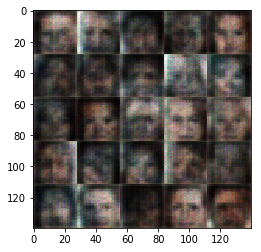

Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 1.1102
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.1231


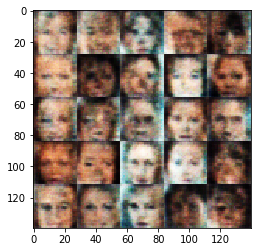

Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 1.2251
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.0334


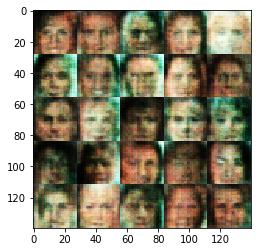

Epoch 1/1... Discriminator Loss: 1.6877... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.6645


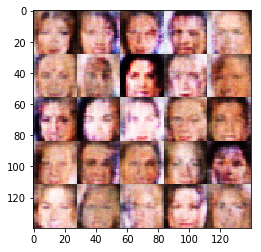

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.5659


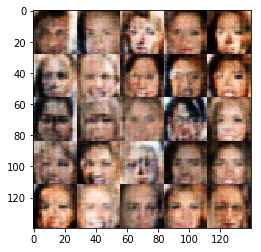

Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8053


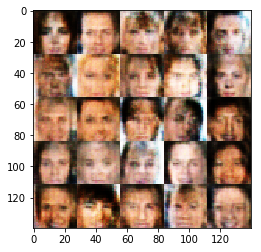

Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7012


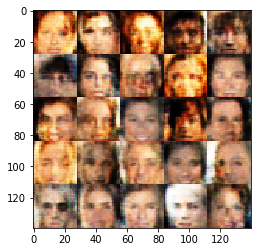

Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8332


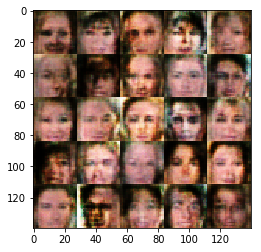

Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.6216


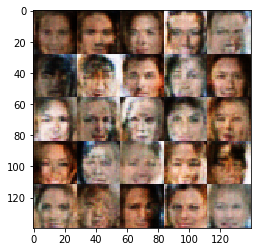

Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.8493


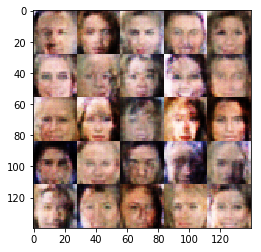

Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.8226


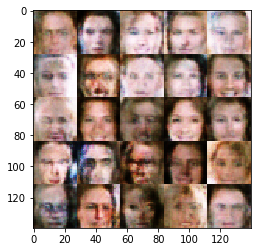

Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.6919


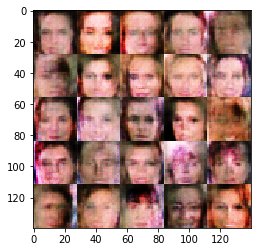

Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.4930


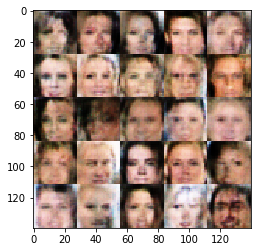

Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.8105


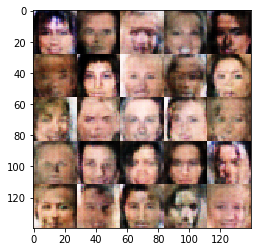

Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.6978


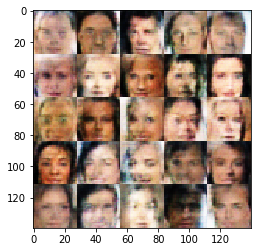

Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.5025


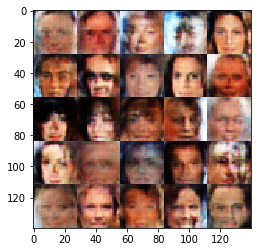

Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.4823
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.6373


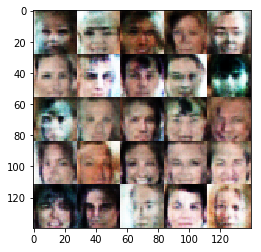

Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.9016


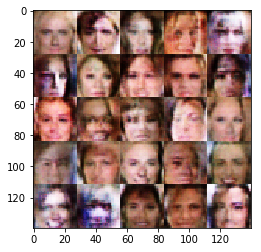

Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.1273
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7033


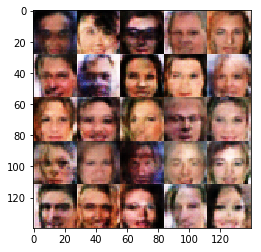

Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.4420
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 1.2231


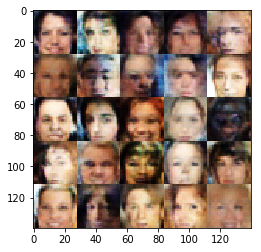

Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.6343


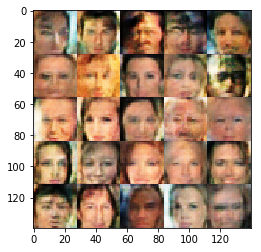

Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.7379


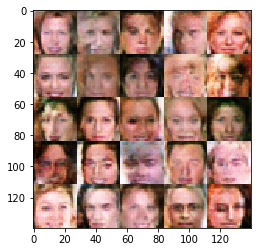

Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.6996


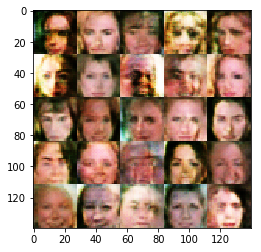

Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 0.9528


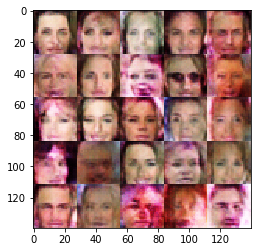

Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.7957


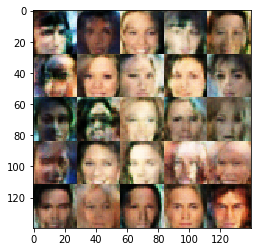

Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.7649


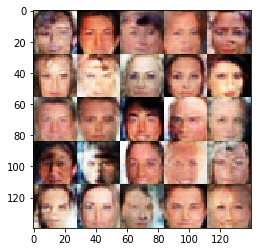

Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.3853
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.9096


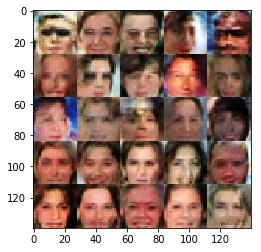

Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.8071


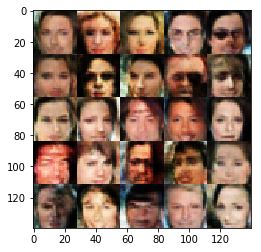

Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.3897
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.6439


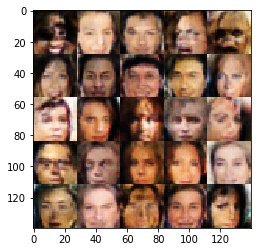

Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.7992


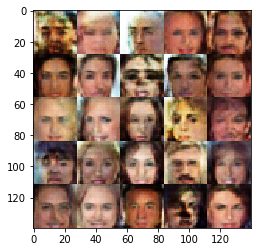

Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.7726


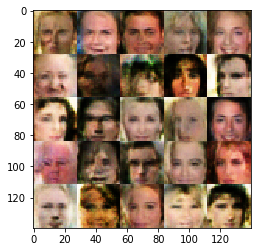

Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.6673


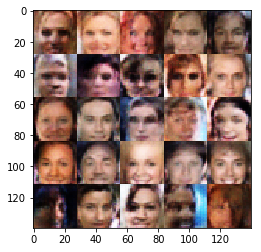

Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6614


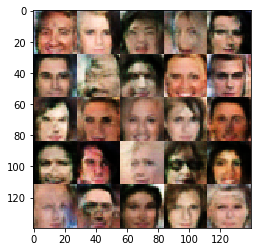

Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.0346


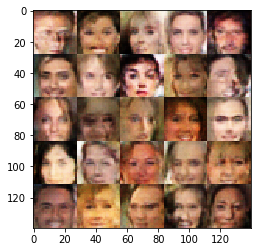

Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.9106


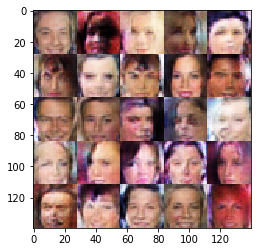

Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.5899... Generator Loss: 0.3358
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9649


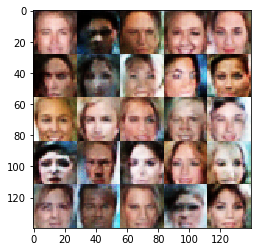

Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.8306


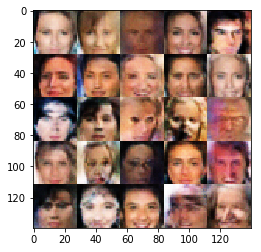

Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.0178


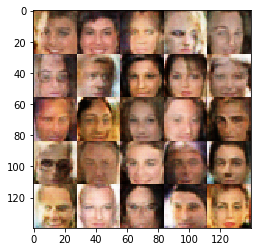

Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.7986


Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.9929


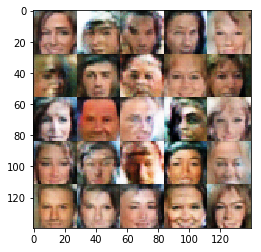

Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.9038


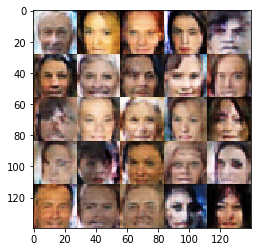

Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.8075


Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.6674


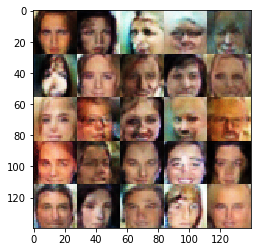

Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.7098


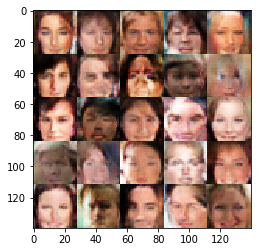

Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.8925


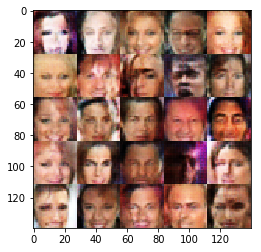

Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.6949


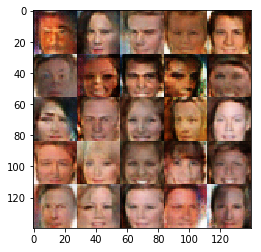

Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.4379
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.0720


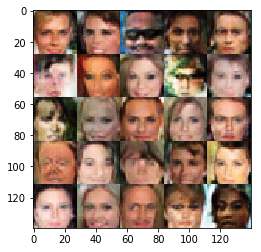

Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7590


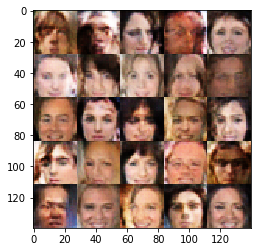

Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.6876


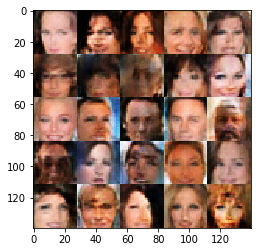

Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.0592
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.8228


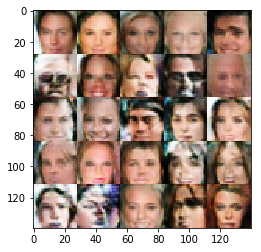

Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 1.0916
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 1.0489


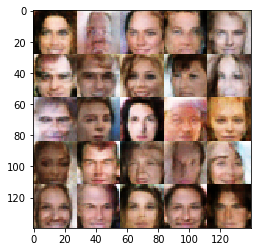

Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.9579


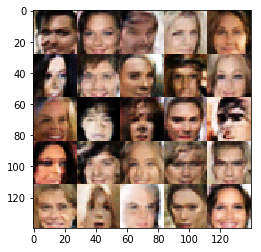

Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.4930
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7727


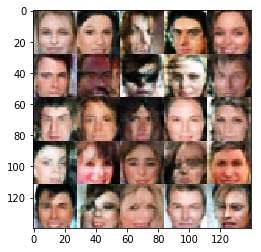

Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.6864


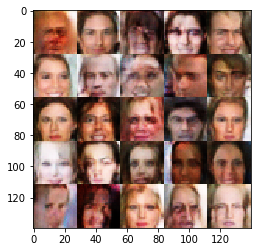

Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.7496


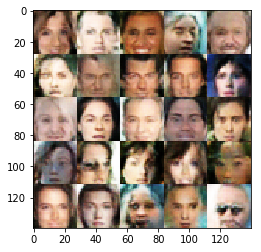

Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.7591


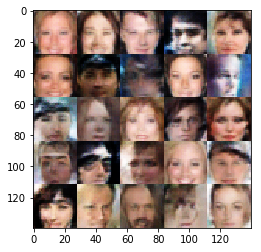

Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7626


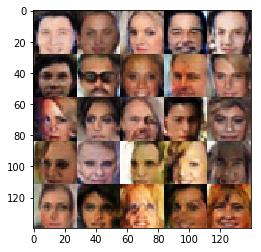

Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.5997


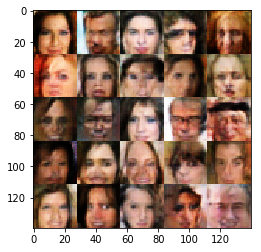

Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.6900


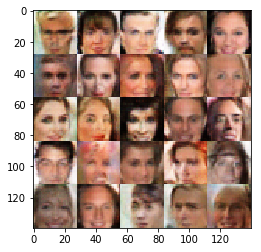

Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.8099


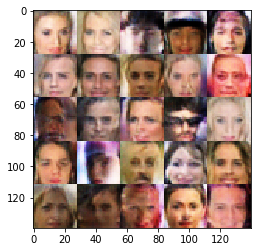

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.6765


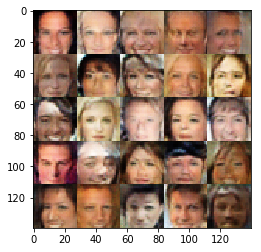

Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.5404


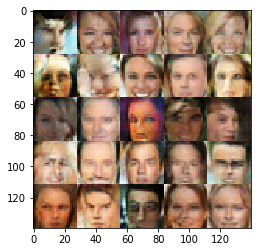

Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 1.0300


In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.